# The Aftermath!
This notebooks single purpose is to try out things that I saw in other presentations, to see what it does to my model

In [1]:
# %load ../scripts/imports.py
import pandas as pd
import numpy as np
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.set_context("talk", font_scale=1.5, rc={"figure.figsize": (20,10)})
sns.set_style("whitegrid")

In [2]:
c_zips =[98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 
          98109, 98112, 98115, 98116, 98117, 98118, 98119, 98121, 
          98122, 98125, 98126, 98133, 98134, 98136, 98144, 98146, 
          98154, 98164, 98174, 98177, 98178, 98195, 98199]

In [3]:
df = pd.read_csv('../data/King_County_House_prices_dataset.csv')
    
#cleaning basement values
df.sqft_basement = df.sqft_basement.replace('?', '-1.0')
df.sqft_basement = df.sqft_basement.astype(float) 
#fixing date dt
df["date"] = pd.to_datetime(df["date"])

In [4]:
df = df[df.zipcode.isin(c_zips)]

In [5]:
'''
#iqr approach
df_iq = df.price
q1 = df.price.quantile(0.55)
q3 = df.price.quantile(0.75)
iqr = q3-q1
df = df[~(df.price < (q1 - 1.5 * iqr)) |
          (df.price > (q3 + 1.5 * iqr))]
df.info()
'''

'\n#iqr approach\ndf_iq = df.price\nq1 = df.price.quantile(0.55)\nq3 = df.price.quantile(0.75)\niqr = q3-q1\ndf = df[~(df.price < (q1 - 1.5 * iqr)) |\n          (df.price > (q3 + 1.5 * iqr))]\ndf.info()\n'

In [6]:
#z-score 
dfz = df[(np.abs(stats.zscore(df.price)) < 1.96)]

<AxesSubplot:xlabel='price', ylabel='Count'>

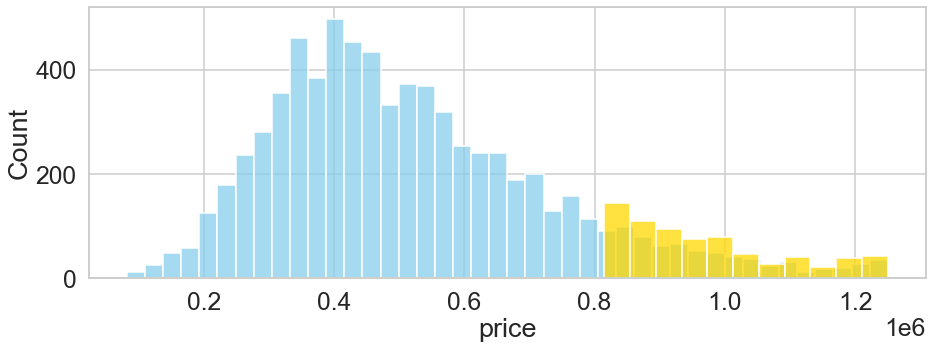

In [7]:
top = dfz[~(dfz.price < dfz.price.quantile(0.9))]
plt.figure(figsize=(15, 5))
sns.histplot(dfz.price, color='skyblue')
sns.histplot(top.price, color='gold')

<AxesSubplot:xlabel='price', ylabel='Count'>

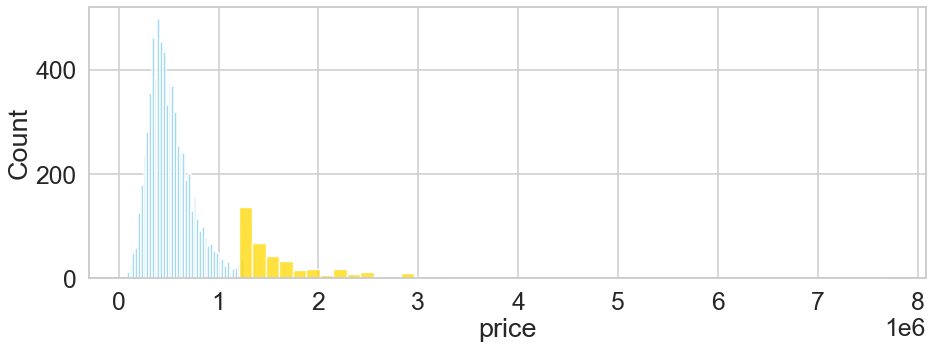

In [8]:
top = df[~(df.price < df.price.quantile(0.95))]
plt.figure(figsize=(15, 5))
sns.histplot(dfz.price, color='skyblue')
sns.histplot(top.price, color='gold')

<AxesSubplot:xlabel='price', ylabel='Count'>

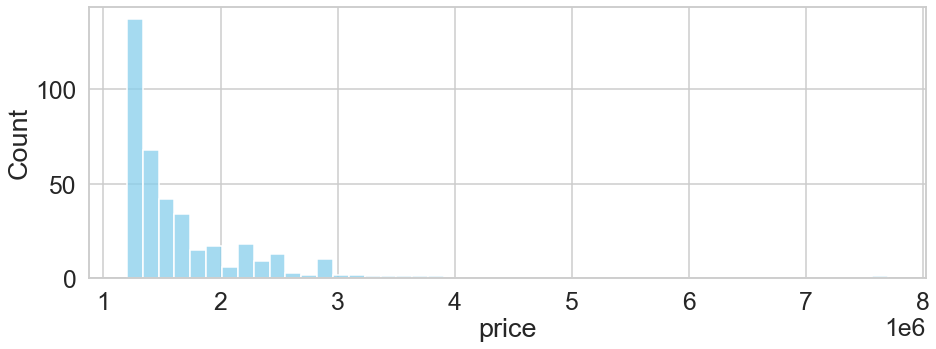

In [9]:
plt.figure(figsize=(15, 5))
sns.histplot(top.price, color='skyblue')

<AxesSubplot:xlabel='price', ylabel='Count'>

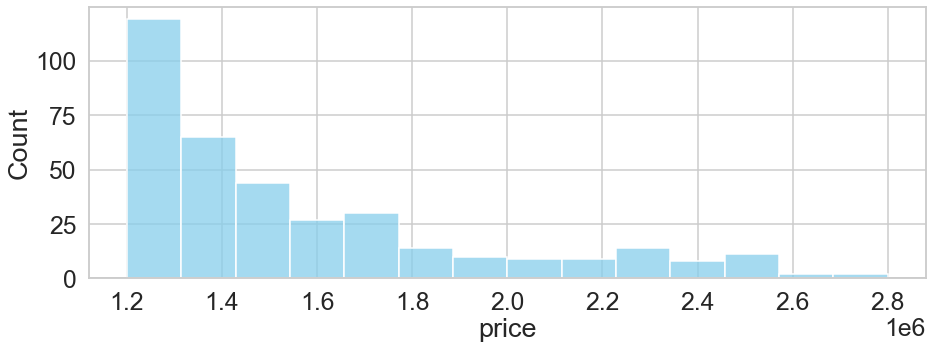

In [10]:
top = top[(np.abs(stats.zscore(top.price)) < 1.96)]
plt.figure(figsize=(15, 5))
sns.histplot(top.price, color='skyblue')

In [11]:
top.info()
df = top

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 282 to 21489
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             364 non-null    int64         
 1   date           364 non-null    datetime64[ns]
 2   price          364 non-null    float64       
 3   bedrooms       364 non-null    int64         
 4   bathrooms      364 non-null    float64       
 5   sqft_living    364 non-null    int64         
 6   sqft_lot       364 non-null    int64         
 7   floors         364 non-null    float64       
 8   waterfront     333 non-null    float64       
 9   view           361 non-null    float64       
 10  condition      364 non-null    int64         
 11  grade          364 non-null    int64         
 12  sqft_above     364 non-null    int64         
 13  sqft_basement  364 non-null    float64       
 14  yr_built       364 non-null    int64         
 15  yr_renovated   301 

In [12]:
explanatory_vars = ['sqft_living', 'sqft_lot',
                    'floors', 'sqft_above', 'yr_built', 'yr_renovated',
                    'sqft_basement', 'lat', 'long','sqft_living15', 'sqft_lot15']
categoricals = ['bedrooms', 'bathrooms', 'waterfront', 'view', 'condition', 'grade', 'zipcode',]

In [13]:
#see what correlates with price
c = df.corr()['price'][2:]
c.sort_values(ascending=False)
explanatory_vars = [ e for e in c[c.values > 0.5].index if e in explanatory_vars]
categoricals = [ ca for ca in c[c.values > 0.5].index if ca in categoricals]
all_exp = explanatory_vars+categoricals
print(explanatory_vars+categoricals)

['sqft_living', 'sqft_above']


<AxesSubplot:>

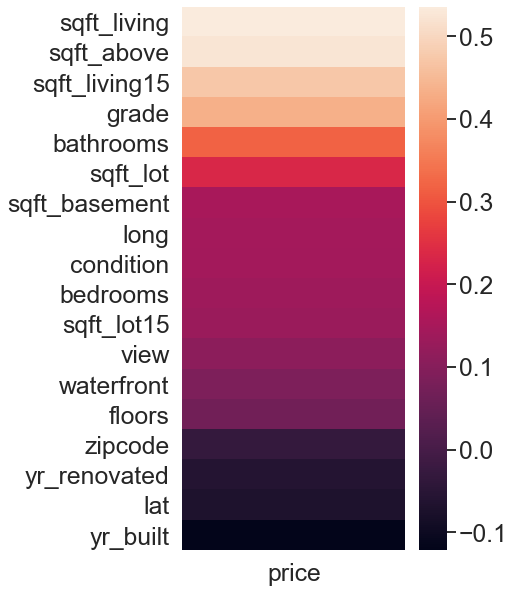

In [14]:
plt.figure(figsize=(5, 10))
sns.heatmap(df.corr()[['price']][2:].sort_values(by='price', ascending=False))

R squared for each possible explanatory variable:


ValueError: x and y must be the same size

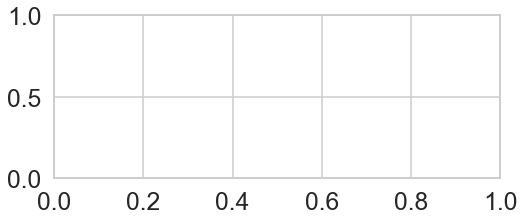

In [32]:
print('R squared for each possible explanatory variable:' )
for explanatory_var in all_exp:
    X = df[explanatory_var]
    X = sm.add_constant(X)
    model = sm.OLS(df.price, X)
    result = model.fit()
    pre = result.predict()
    rs = smf.ols(formula='price ~ (np.log(sqft_living))+1', data=df[['price', 'sqft_living']]).fit()
    #print('{:7s} \t \t= {:.3}'.format(explanatory_var, rs))
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.scatter(df[explanatory_var], rs, alpha=0.5)
    ax.set_ylabel("Residuals")
    ax.set_xlabel(explanatory_var)

In [16]:
df = df[(np.abs(stats.zscore(df[all_exp])) < 1.96).any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 282 to 21489
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             356 non-null    int64         
 1   date           356 non-null    datetime64[ns]
 2   price          356 non-null    float64       
 3   bedrooms       356 non-null    int64         
 4   bathrooms      356 non-null    float64       
 5   sqft_living    356 non-null    int64         
 6   sqft_lot       356 non-null    int64         
 7   floors         356 non-null    float64       
 8   waterfront     325 non-null    float64       
 9   view           353 non-null    float64       
 10  condition      356 non-null    int64         
 11  grade          356 non-null    int64         
 12  sqft_above     356 non-null    int64         
 13  sqft_basement  356 non-null    float64       
 14  yr_built       356 non-null    int64         
 15  yr_renovated   293 

In [17]:
'''
#removing outliers
outl = all_exp
df_iq = df[outl]
q1 = df[outl].quantile(0.25)
q3 = df[outl].quantile(0.75)
iqr = q3-q1
df = df[~((df[outl] < (q1 - 1.5 * iqr)) |
          (df[outl] > (q3 + 1.5 * iqr))).any(axis=1)]
df.info()
'''

'\n#removing outliers\noutl = all_exp\ndf_iq = df[outl]\nq1 = df[outl].quantile(0.25)\nq3 = df[outl].quantile(0.75)\niqr = q3-q1\ndf = df[~((df[outl] < (q1 - 1.5 * iqr)) |\n          (df[outl] > (q3 + 1.5 * iqr))).any(axis=1)]\ndf.info()\n'

In [18]:
explanatory_vars = ['sqft_living', 'sqft_lot',
                    'floors', 'sqft_above', 'yr_built',
                    'sqft_basement', 'lat', 'long','sqft_living15', 'sqft_lot15']
categoricals = ['bedrooms', 'bathrooms', 'condition', 'grade', 'zipcode',]

In [19]:
#see what changes after outliers removed -> bathroom gone
c = df.corr()['price'][2:]
c.sort_values(ascending=False)
explanatory_vars = [ e for e in c[c.values > 0].index if e in explanatory_vars]
categoricals = [ ca for ca in c[c.values > 0.1].index if ca in categoricals]
all_exp = explanatory_vars+categoricals
print(all_exp)

['sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'long', 'sqft_living15', 'sqft_lot15', 'bedrooms', 'bathrooms', 'condition', 'grade']


<AxesSubplot:>

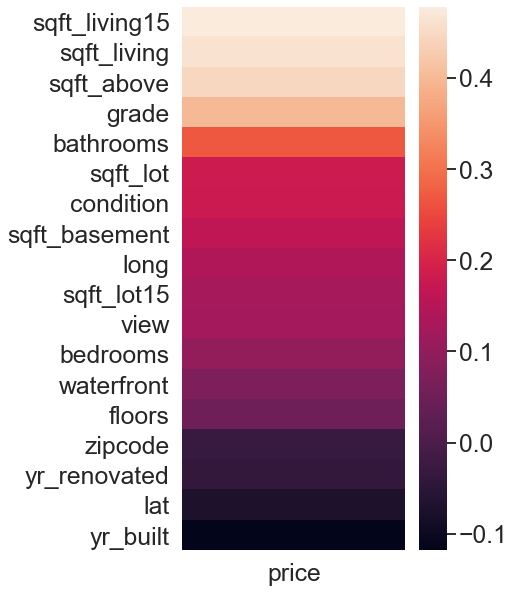

In [20]:
plt.figure(figsize=(5, 10))
sns.heatmap(df.corr()[['price']][2:].sort_values(by='price', ascending=False))

R squared for each possible explanatory variable:


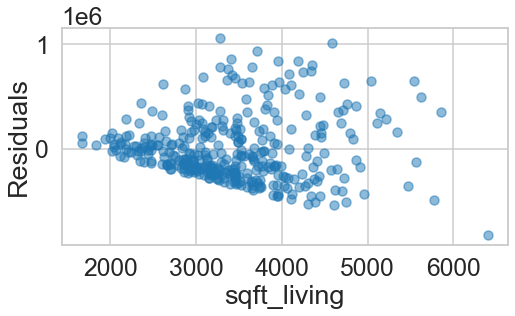

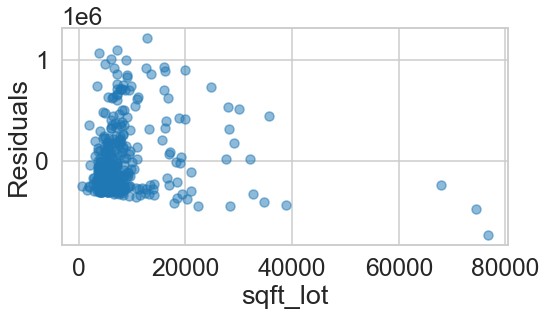

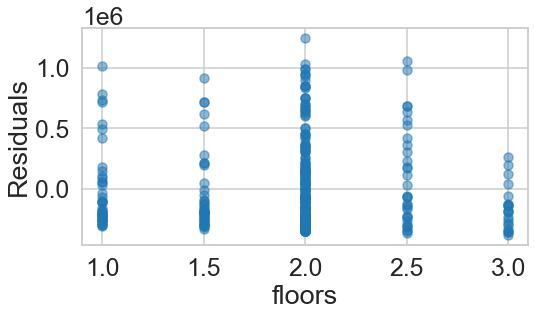

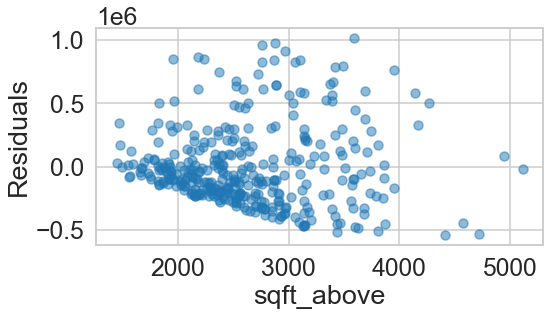

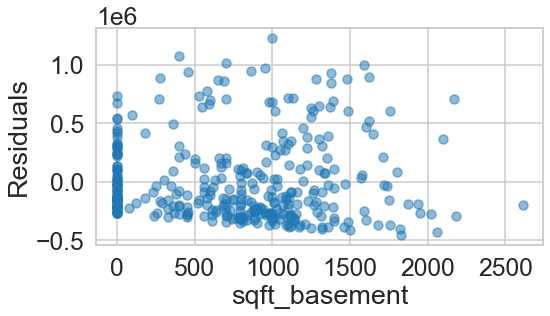

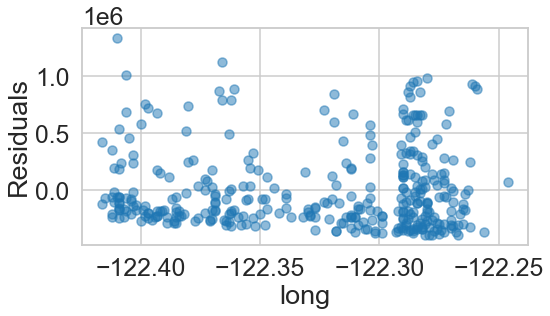

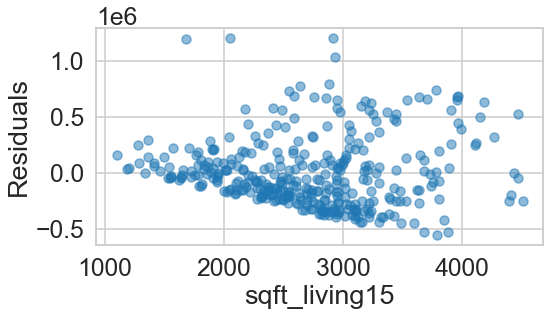

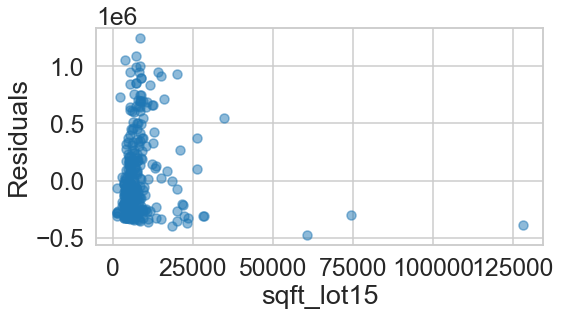

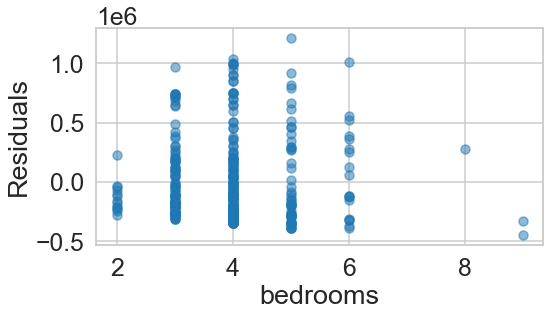

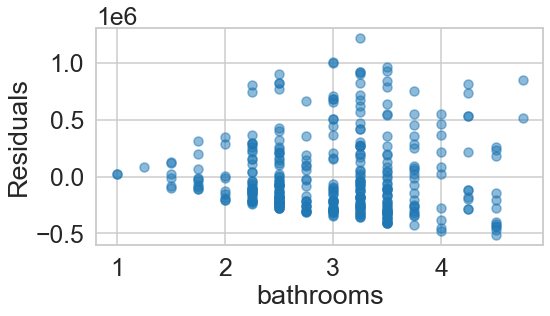

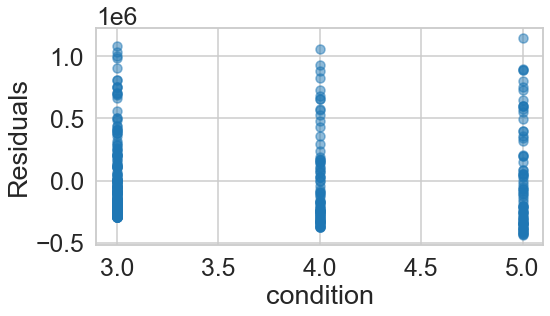

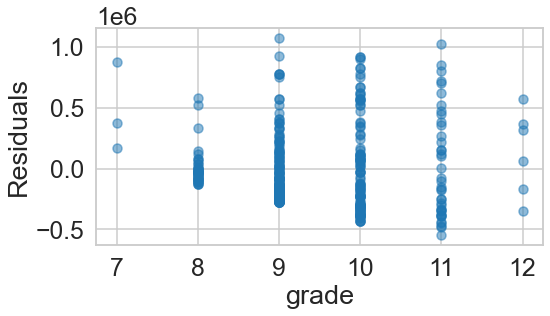

In [21]:
print('R squared for each possible explanatory variable:' )
for explanatory_var in all_exp:
    X = df[explanatory_var]
    X = sm.add_constant(X)
    model = sm.OLS(df.price, X)
    result = model.fit()
    pre = result.predict()
    rs = result.resid
    #print('{:7s} \t \t= {:.3}'.format(explanatory_var, rs))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(df[explanatory_var], rs, alpha=0.5)
    ax.set_ylabel("Residuals")
    ax.set_xlabel(explanatory_var)

Text(0.5, 0, 'All explanatories')

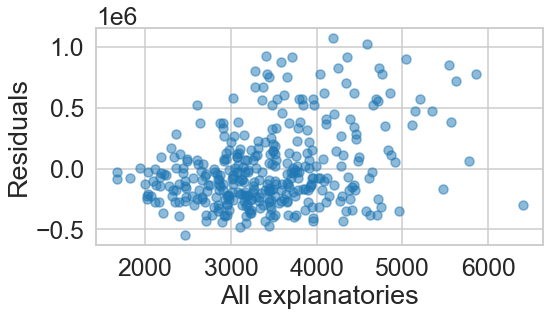

In [22]:
# so what to do with this: when Amy decides what price she could expect for her asset.
# we can now use her asset data and tell her. we only need sqft data example
X = df.grade
X = sm.add_constant(X)
model = sm.OLS(df.price, X)
result = model.fit()
pre = result.predict()
rs = result.resid
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(df.sqft_living, rs, alpha=0.5)
ax.set_ylabel("Residuals")
ax.set_xlabel('All explanatories')

In [23]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     67.64
Date:                Mon, 22 Feb 2021   Prob (F-statistic):           3.77e-15
Time:                        12:15:16   Log-Likelihood:                -5020.7
No. Observations:                 356   AIC:                         1.005e+04
Df Residuals:                     354   BIC:                         1.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.128e+05   1.75e+05      0.644      0.520   -2.32e+05    4.57e+05
grade       1.515e+05   1.84e+04      8.225      0.000    1.15e+05    1.88e+05
==============================================================================
Omnibus:                       57.972   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.841
Skew:                           1.115   Prob(JB):                     1.69e-18
Kurtosis:                       3.739   Cond. No.                         98.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
#predict price
e_house = df[all_exp][df.id == df.id.values[1]].values
e_house = e_house.flatten()
e_house
p = result.predict([1.0, 2730, 2130, 2730, 8])
print('Price for the example house will probably be around {:}'.format(p[0]))

ValueError: shapes (1,5) and (2,) not aligned: 5 (dim 1) != 2 (dim 0)

In [ ]:
#show price over time
osk_zip_pivot = pd.pivot_table(df[['zipcode', 'date', 'price']], values='price', index=['date'], columns=['zipcode']).reset_index()
osk_zip_pivot.fillna(0, inplace=True)
osk_zip_pivot = osk_zip_pivot.resample('W', on='date').mean().reset_index()
osk_zip_pivot = osk_zip_pivot.add_suffix('_zip')
px.line(osk_zip_pivot, x='date_zip', y=osk_zip_pivot.columns)